In [1]:
import pandas as pd
import numpy as np
import gzip
import re
import seaborn as sns
import matplotlib as plt

P=0.05

In [3]:
#dictionary samples
table_sample=pd.read_csv("/private1/private/data/cllmap/metadata/all_deidentifier_patAndSamp_20220308.tsv",sep='\t')
# table_cllmap=pd.read_csv("/home/ls/rachelcw/projects/cllmap_pat_samp_id_map.extended.20221205.tsv",sep='\t')
# rna_id=list(table_cllmap['rna_tumor_sample_id'].dropna())
dict_sample=dict(zip(table_sample[table_sample.columns[0]],table_sample[table_sample.columns[1]]))

In [17]:
cll_data=pd.read_csv("/home/ls/rachelcw/projects/leafcutter_git/cll_data.csv")
#data.drop(columns=data.columns[0], inplace=True)

groups_file_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.analysis.20230108/'

In [18]:
master_table=pd.read_csv("/home/ls/rachelcw/projects/cllmap_rnaseq_tpms_603samps_deseqLog10_batchcorr.tsv",sep="\t")

In [19]:
dhx15=master_table.loc[(master_table['Description']=='DHX15')]
dhx15=dhx15.drop(columns=["Name"])
dhx15.set_index('Description',inplace=True)
dhx15_t=dhx15.T

In [20]:
cll_data=cll_data.merge(dhx15_t,right_index=True,left_on='key')

In [21]:
cll_data['ighv_mut'] = cll_data['ighv_mut'].replace(['unmutated', 'mutated'], ['U-CLL', 'M-CLL'])

In [32]:
# effect_sizes=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/ds.a2.20221226_effect_sizes.txt",sep="\t")
# cluster=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/ds.a2.20221226_cluster_significance.txt",sep=" ")
# print(effect_sizes.shape)
# print(cluster.shape)

In [10]:
# covariates table for DS 
covariate_table=pd.read_csv("/home/ls/rachelcw/projects/PEER/covariates_table_20230109.csv", index_col=0)

# convert binary data to labels #
# # F - M
covariate_table['F']=covariate_table['F'].replace([1,0],['F','M'])
covariate_table.drop(columns='M', inplace=True)
covariate_table.rename(columns={'F':'F/M'},inplace=True)
# # S-spain vs B-broad
covariate_table['seqcenter_Spain']=covariate_table['seqcenter_Spain'].replace([1,0],['S','B'])
covariate_table.drop(columns='seqcenter_Broad', inplace=True)
covariate_table.rename(columns={'seqcenter_Spain':'seqcenter'},inplace=True)
## LCSET
covariate_table['LCSET']=''
for col in covariate_table.filter(regex="^LCSET_").columns:
    covariate_table[col]=covariate_table[col].replace([1,0],[col,''])
    covariate_table['LCSET']= covariate_table['LCSET'] + covariate_table[col]

covariate_table=covariate_table.loc[:,~covariate_table.columns.str.startswith('LCSET_')]
covariate_table = covariate_table.mask(covariate_table=='')


In [11]:
# # analysis #1 : ucll+mcll - u SF3B1 - low\high SUGP1 # #

# Unmutated SF3B1
data_unmut=cll_data[cll_data['SF3B1_mut']=='Unmutated SF3B1']
#SUGP1 expression P low
n=round(len(data_unmut)*P)
low_sugp1=data_unmut.nsmallest(n, columns='SUGP1_ex', keep='all')['key']
#SUGP1 expression P high
high_sugp1=data_unmut.nlargest(n, columns='SUGP1_ex', keep='all')['key']
sample_sugp1=list(low_sugp1)+list(high_sugp1)
analysis1=covariate_table.filter(items=sample_sugp1, axis='index')

#  create a file that specifies which samples go in each group- low vs. high 
groups_file=open(groups_file_path+"groups_file_a1.txt",'w')
for sample in low_sugp1:
    groups_file.writelines([sample, '\tlow\t',analysis1.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in high_sugp1:
    groups_file.writelines([sample, '\thigh\t',analysis1.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

In [12]:
# # analysis #2 : ucll+mcll - u SF3B1 - m SF3B1 # #

# Unmutated SF3B1
unmut_sample=cll_data[cll_data['SF3B1_mut']=='Unmutated SF3B1']['key']
# mutated SF3B1
mut_sample=cll_data[cll_data['SF3B1_mut']=='Mutated SF3B1']['key']

samples=list(unmut_sample)+list(mut_sample)
analysis2=covariate_table.filter(items=samples, axis='index')

#  create a file that specifies which samples go in each group- unmut vs. mut 
groups_file=open(groups_file_path+"groups_file_a2.txt",'w')
for sample in unmut_sample:
    groups_file.writelines([sample, '\tunmut\t',analysis2.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in mut_sample:
    groups_file.writelines([sample, '\tmut\t',analysis2.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

In [13]:
# # analysis #7 : ucll+mcll - u SF3B1 - low\high DHX15 # #

# Unmutated SF3B1
data_unmut=cll_data[cll_data['SF3B1_mut']=='Unmutated SF3B1']
#DHX15 expression P low
n=round(len(data_unmut)*P)
low_dhx15=data_unmut.nsmallest(n, columns='DHX15', keep='all')['key']
#DHX15 expression P high
high_dhx15=data_unmut.nlargest(n, columns='DHX15', keep='all')['key']
sample_dhx15=list(low_dhx15)+list(high_dhx15)
analysis7=covariate_table.filter(items=sample_dhx15, axis='index')

#  create a file that specifies which samples go in each group- low vs. high 
groups_file=open(groups_file_path+"groups_file_a7.txt",'w')
for sample in low_dhx15:
    groups_file.writelines([sample, '\tlow\t',analysis7.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in high_dhx15:
    groups_file.writelines([sample, '\thigh\t',analysis7.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

In [22]:
# # analysis #3 : mcll - u SF3B1 - low\high SUGP1 # #

# m- cll
data_mcll=cll_data[cll_data['ighv_mut']=='M-CLL']
# Unmutated SF3B1
data_unmut=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']
#SUGP1 expression 10% low
n=round(len(data_unmut)*P)
low_sugp1=data_unmut.nsmallest(n, columns='SUGP1_ex', keep='all')['key']
#SUGP1 expression 10% low
high_sugp1=data_unmut.nlargest(n, columns='SUGP1_ex', keep='all')['key']
sample_sugp1=list(low_sugp1)+list(high_sugp1)
analysis3=covariate_table.filter(items=sample_sugp1, axis='index')

#  create a file that specifies which samples go in each group- low vs. high 
groups_file=open(groups_file_path+"groups_file_a3.txt",'w')
for sample in low_sugp1:
    groups_file.writelines([sample, '\tlow\t',analysis3.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in high_sugp1:
    groups_file.writelines([sample, '\thigh\t',analysis3.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

/tmp/ipykernel_1935491/816173348.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_unmut=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']


In [23]:
# # analysis #4 : mcll - u SF3B1 - m SF3B1 # #

# m- cll
data_mcll=cll_data[cll_data['ighv_mut']=='M-CLL']
# Unmutated SF3B1
unmut_sample=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']['key']
# mutated SF3B1
mut_sample=data_mcll[cll_data['SF3B1_mut']=='Mutated SF3B1']['key']

samples=list(unmut_sample)+list(mut_sample)
analysis4=covariate_table.filter(items=samples, axis='index')

#  create a file that specifies which samples go in each group- unmut vs. mut 
groups_file=open(groups_file_path+"groups_file_a4.txt",'w')
for sample in unmut_sample:
    groups_file.writelines([sample, '\tunmut\t',analysis4.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in mut_sample:
    groups_file.writelines([sample, '\tmut\t',analysis4.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

/tmp/ipykernel_1935491/265561118.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unmut_sample=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']['key']
/tmp/ipykernel_1935491/265561118.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mut_sample=data_mcll[cll_data['SF3B1_mut']=='Mutated SF3B1']['key']


In [24]:
# # analysis #8 : mcll - u SF3B1 - low\high DHX15 # #

# m- cll
data_mcll=cll_data[cll_data['ighv_mut']=='M-CLL']
# Unmutated SF3B1
data_unmut=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']
#DHX15 expression P low
n=round(len(data_unmut)*P)
low_dhx15=data_unmut.nsmallest(n, columns='DHX15', keep='all')['key']
#DHX15 expression P high
high_dhx15=data_unmut.nlargest(n, columns='DHX15', keep='all')['key']
sample_dhx15=list(low_dhx15)+list(high_dhx15)
analysis8=covariate_table.filter(items=sample_dhx15, axis='index')

#  create a file that specifies which samples go in each group- low vs. high 
groups_file=open(groups_file_path+"groups_file_a8.txt",'w')
for sample in low_dhx15:
    groups_file.writelines([sample, '\tlow\t',analysis8.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in high_dhx15:
    groups_file.writelines([sample, '\thigh\t',analysis8.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

/tmp/ipykernel_1935491/2223929579.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_unmut=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']


In [25]:
# # analysis #5 : ucll - u SF3B1 - low\high SUGP1 # #

# m- cll
data_ucll=cll_data[cll_data['ighv_mut']=='U-CLL']
# Unmutated SF3B1
data_unmut=data_ucll[cll_data['SF3B1_mut']=='Unmutated SF3B1']
#SUGP1 expression 10% low
n=round(len(data_unmut)*P)
low_sugp1=data_unmut.nsmallest(n, columns='SUGP1_ex', keep='all')['key']
#SUGP1 expression 10% high
high_sugp1=data_unmut.nlargest(n, columns='SUGP1_ex', keep='all')['key']
sample_sugp1=list(low_sugp1)+list(high_sugp1)
analysis5=covariate_table.filter(items=sample_sugp1, axis='index')

#  create a file that specifies which samples go in each group- low vs. high 
groups_file=open(groups_file_path+"groups_file_a5.txt",'w')
for sample in low_sugp1:
    groups_file.writelines([sample, '\tlow\t',analysis5.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in high_sugp1:
    groups_file.writelines([sample, '\thigh\t',analysis5.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

/tmp/ipykernel_1935491/1791933651.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_unmut=data_ucll[cll_data['SF3B1_mut']=='Unmutated SF3B1']


In [26]:
# # analysis #6 : ucll - u SF3B1 - m SF3B1 # #

# u- cll
data_ucll=cll_data[cll_data['ighv_mut']=='U-CLL']
# Unmutated SF3B1
unmut_sample=data_ucll[cll_data['SF3B1_mut']=='Unmutated SF3B1']['key']
# mutated SF3B1
mut_sample=data_ucll[cll_data['SF3B1_mut']=='Mutated SF3B1']['key']

samples=list(unmut_sample)+list(mut_sample)
analysis6=covariate_table.filter(items=samples, axis='index')

#  create a file that specifies which samples go in each group- unmut vs. mut 
groups_file=open(groups_file_path+"groups_file_a6.txt",'w')
for sample in unmut_sample:
    groups_file.writelines([sample, '\tunmut\t',analysis6.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in mut_sample:
    groups_file.writelines([sample, '\tmut\t',analysis6.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

/tmp/ipykernel_1935491/1630656844.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unmut_sample=data_ucll[cll_data['SF3B1_mut']=='Unmutated SF3B1']['key']
/tmp/ipykernel_1935491/1630656844.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mut_sample=data_ucll[cll_data['SF3B1_mut']=='Mutated SF3B1']['key']


In [27]:
# # analysis #9 : ucll - u SF3B1 - low\high DHX15 # #

# u- cll
data_mcll=cll_data[cll_data['ighv_mut']=='U-CLL']
# Unmutated SF3B1
data_unmut=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']
#DHX15 expression P low
n=round(len(data_unmut)*P)
low_dhx15=data_unmut.nsmallest(n, columns='DHX15', keep='all')['key']
#DHX15 expression P high
high_dhx15=data_unmut.nlargest(n, columns='DHX15', keep='all')['key']
sample_dhx15=list(low_dhx15)+list(high_dhx15)
analysis9=covariate_table.filter(items=sample_dhx15, axis='index')

#  create a file that specifies which samples go in each group- low vs. high 
groups_file=open(groups_file_path+"groups_file_a9.txt",'w')
for sample in low_dhx15:
    groups_file.writelines([sample, '\tlow\t',analysis9.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
for sample in high_dhx15:
    groups_file.writelines([sample, '\thigh\t',analysis9.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
groups_file.close()

/tmp/ipykernel_1935491/430785336.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_unmut=data_mcll[cll_data['SF3B1_mut']=='Unmutated SF3B1']


In [26]:
#   #   #   SHUFFLE    #   #   #
import random
for i in ['1','2','3','4','5','6','7','8','9']:
    input_file='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.analysis.20230108/groups_file_a'+i+'.txt'
    with open(input_file,'r') as source:
        data = [ (random.random(), line) for line in source ]
    data.sort()
    output_file='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.shuffle.20230116/groups_file_s'+i+'.txt'
    with open(output_file,'w') as target:
        for _, line in data:
            target.write( line )

In [18]:
#   #   RUN LEAFCUTTER DS   #   #
# docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20230108/lc_20230108_perind_numers.counts.gz /data/DS/DS.five_percent/groups_file.analysis.20230108/groups_file_a2.txt -o /data/DS/DS.five_percent/ds.a2.20230108 -p 12
# docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20221211/lc_20221211_perind_numers.counts.gz /data/DS/DS.five_percent/shuffle_groups_file/groups_file_s6.txt -o /data/DS/DS.five_percent/ds.s6.20221227 -p 6


In [ ]:
#   #   DS result anf filtering    #   #
FDR = 0.1

for i in ['9']:
    input_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/ds.a'+i+'.20230115'
    cluster_sig= pd.read_table(input_path+'_cluster_significance.txt',sep='\t')
    #filter out all clusters that they arnt sugnificant <=0.05

    cluster_sig=cluster_sig[cluster_sig['p.adjust'] <= FDR]
    clusters=list(cluster_sig['cluster'].str.split(':',expand=True)[0]+'.*'+cluster_sig['cluster'].str.split(':',expand=True)[1])

    effect_sizes=pd.read_table(input_path+'_effect_sizes.txt',sep='\t')

    #   #   #   #   #   #   #   #   #   #   #   #  

    filtered_intron=[]
    intron=list(effect_sizes['intron'])
    for x in clusters:
        for y in intron:
            r = re.compile(x)
            z=r.search(y)
            if z != None:
                filtered_intron.append(z.string)


    #   #   #   #   #   #   #   #   #   #   #   #              

    effect_sizes.set_index('intron', inplace=True)
    effect_sizes=effect_sizes.filter(items=filtered_intron,axis='index')

    #   #   #   #   #   #   #   #   #   #   #   #   
    output_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered0.1.a' + i + '.20230115'
    print(output_path)

    cluster_sig.to_csv(output_path+'_cluster_significance.txt', sep=' ',index=False)
    effect_sizes.to_csv(output_path+'_effect_sizes.txt', sep=' ')



In [17]:
a1=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a1.20230115_cluster_significance.txt", sep=' ')
a2=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a2.20230115_cluster_significance.txt", sep=' ')
a3=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a3.20230115_cluster_significance.txt", sep=' ')
a4=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a4.20230115_cluster_significance.txt", sep=' ')
a6=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a6.20230115_cluster_significance.txt", sep=' ')
a7=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a7.20230115_cluster_significance.txt", sep=' ')
a8=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/filtered.a8.20230115_cluster_significance.txt", sep=' ')


[Text(0, 0, 'mucll-lh'),
 Text(1, 0, 'mucll-mu'),
 Text(2, 0, 'mucll-DHX15'),
 Text(3, 0, 'mcll-lh'),
 Text(4, 0, 'mcll-mu'),
 Text(5, 0, 'mcll-DHX15'),
 Text(6, 0, 'ucll-lh'),
 Text(7, 0, 'ucll-mu'),
 Text(8, 0, 'ucll-DHX15')]

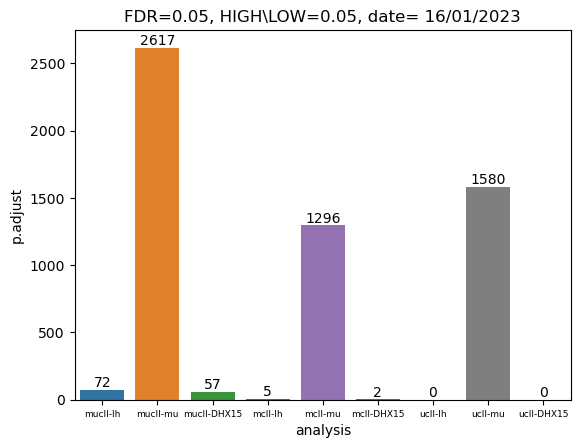

In [18]:
FDR=0.05
plot_pa=pd.DataFrame({'analysis':['mucll-lh','mucll-mu','mucll-DHX15','mcll-lh','mcll-mu','mcll-DHX15','ucll-lh','ucll-mu','ucll-DHX15'],'p.adjust':[len(a1['p.adjust']),len(a2['p.adjust']),len(a7['p.adjust']),len(a3['p.adjust']),len(a4['p.adjust']),len(a8['p.adjust']),0,len(a6['p.adjust']),0]},)

ax=sns.barplot(plot_pa,x='analysis',y='p.adjust')
ax.bar_label(ax.containers[0])
ax.set(title=f'FDR={FDR}, HIGH\LOW={P}, date= 16/01/2023')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=6.5)


In [3]:
# sugp1_lh=pd.merge(a3,a5, how='inner', on='cluster')
# #sugp1_lh=pd.merge(sugp1_lh,a5, how='inner', on='cluster')
# sugp1_lh.set_index('cluster',inplace=True)
sf3b1_mu=pd.merge(a2,a4,how='inner',on='cluster')
sf3b1_mu=pd.merge(sf3b1_mu,a6,how='inner',on='cluster')
sf3b1_mu.set_index('cluster',inplace=True)


In [21]:
sf3b1_mu.to_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/sf3b1_mu_cs.csv")

In [16]:
b2=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/ds.a2.20221221_effect_sizes.txt",sep='\t')
b4=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/ds.a4.20221221_effect_sizes.txt",sep='\t')
b6=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/ds.a6.20221221_effect_sizes.txt",sep='\t')

In [17]:
sf3b1_mu=sf3b1_mu.reset_index()
clusters=list(sf3b1_mu['cluster'].str.split(':',expand=True)[0]+'.*'+sf3b1_mu['cluster'].str.split(':',expand=True)[1])



In [19]:
filtered_intron=[]
intron=list(b6['intron'])
for x in clusters:
    for y in intron:
        r = re.compile(x)
        i=r.search(y)
        if i != None:
            filtered_intron.append(i.string)

b6.set_index('intron', inplace=True)
b6=b6.filter(items=filtered_intron,axis='index')

In [20]:
sf3b1_mu_es=pd.merge(b2,b4,how='inner',on='intron')
sf3b1_mu_es=pd.merge(sf3b1_mu_es,b6,how='inner',on='intron')
#sf3b1_mu.set_index('cluster',inplace=True)

In [ ]:
sf3b1_mu_es.to_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/sf3b1_mu_es.csv")

In [13]:
# effect_sizes['intron'].str.split(':',expand=True)
# cluster=effect_sizes['intron'].str.split(':',expand=True)[3]
# chr=effect_sizes['intron'].str.split(':',expand=True)[0]
# effect_sizes['cluster']=cluster
# effect_sizes['chr']=chr

# es=[]
# for value in effect_sizes['deltapsi']:
#     if abs(value)<=0.3:
#         es.append('small')
#     elif abs(value)<=0.5:
#         es.append('medium')
#     else:
#         es.append('large')

# effect_sizes['es']=es

In [ ]:
#/home/ls/rachelcw/projects/LEAFCUTTER/leafcutter/scripts/ds_plots.R -e /home/ls/rachelcw/projects/LEAFCUTTER/leafcutter/data/gencode19_exons.txt.gz /home/ls/rachelcw/projects/LEAFCUTTER/lc_20221211/lc_20221211_perind_numers.counts.gz /home/ls/rachelcw/projects/LEAFCUTTER/groups_file_peer.txt /home/ls/rachelcw/projects/LEAFCUTTER/DS/lc_ds_20221213_cluster_significance.txt -f 0.05

In [ ]:
docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20230108/lc_20230108_perind_numers.counts.gz /data/DS/DS.five_percent/groups_file.shuffle.20230116/groups_file_s7.txt -o /data/DS/DS.five_percent/shuffle.20230116/ds.s7.20230116 -p 12 --init random --seed 613